In [38]:
import os
import subprocess
from pathlib import Path

import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import tifffile
from einops import rearrange
from ome_types import from_tiff
from skimage.color import label2rgb
from skimage.measure import regionprops_table

We'll use this breast cancer sample for the example: **20240705_Human_BRCA_HT704B1_CODEX_1**

Setting run directory for the example

In [4]:
sid = '20240705_Human_BRCA_HT704B1_CODEX_1'

output_dir = Path(f'../data/{sid}')
output_dir.mkdir(parents=True, exist_ok=True)

## Step 1: Conversion of phenocycler QPTIFF to OME-TIF

To run the rest of the pipeline, we need to convert the .qptiff file output by the phenocycler to a .ome.tif file.

To do so we'll use the [multiplex-imaging-pipeline](https://github.com/estorrs/multiplex-imaging-pipeline). Note that there are multiple options for the `make-ome` command, such as cropping with a bounding box. 


For illustrative purposes, we'll invoke it from the command line. See more details in the [multiplex-imaging-pipeline documentation](https://github.com/estorrs/multiplex-imaging-pipeline).

In [8]:
qptiff_path = Path(
    '/diskmnt/primary/CODEX/HTAN/20240705_Human_BRCA_HT704B1_CODEX_1/HT704B1-CODEX-1_Scan1.qptiff'
)

ome_path = output_dir / f'{sid}.ome.tiff' 

Generating the make-ome command

In [9]:
command = f'mip make-ome \
--input-tif {qptiff_path} \
--platform phenocycler \
--output-filepath {ome_path}'
command

'mip make-ome --input-tif /diskmnt/primary/CODEX/HTAN/20240705_Human_BRCA_HT704B1_CODEX_1/HT704B1-CODEX-1_Scan1.qptiff --platform phenocycler --output-filepath ../data/20240705_Human_BRCA_HT704B1_CODEX_1/20240705_Human_BRCA_HT704B1_CODEX_1.ome.tiff'

Run from command line via subprocess

In [10]:
_ = subprocess.check_output(command, shell=True)

2025-09-08 11:56:23.668875: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /diskmnt/Users2/estorrs/miniconda3/envs/multiplex-imaging/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/lib:/usr/lib64:/usr/local/lib:/usr/lib64:
2025-09-08 11:56:23.668924: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-09-08 11:56:29,837 - 38 total markers
2025-09-08 11:56:29,837 - writing as uint8
2025-09-08 11:56:33,620 - loading DAPI
2025-09-08 11:56:54,942 - loading Granzyme B
2025-09-08 11:57:09,481 - loading Keratin 5
2025-09-08 11:57:23,768 - loading PLAT/tPA (D)
2025-09-08 11:57:39,110 - loading CTLA4 (D)
2025-09-08 11:57:52,908 - loading CD31
2025-09-08 11:58:05,803 - loading CD4 (D)
2025-09-08 11:58:19,387 - loading SLC39A6 (D)
2025-09

## Step 2: Cell segmentation

In [11]:
ome_path = output_dir / f'{sid}.ome.tiff'
assert ome_path.is_file() # making sure file exists

We will now run cell segmentation using deepcell. For more details refer to the [multiplex-imaging-pipeline documentation](https://github.com/estorrs/multiplex-imaging-pipeline).

Note that selection of membrane segmentation markers may change run to run based on tissue type, panel, etc.

In [18]:
# nuclei channel for nuclei segmentation
nuclei_marker = 'DAPI'

# membrane markers for cell segmentation
membrane_markers = [
    'Pan-Cytokeratin',
    'HLA-DR',
    'CD3e',
    'CD4 (D)',
    'Vimentin'
]
membrane_str = ','.join(membrane_markers)

# image will be split into grids of 10,000 x 10,000 pixels for segmentation
# if you run into memory issues, decrease this number
split_size = 10000

# prefix to be used for segmentation output files
output_prefix = output_dir / f'{sid}'

generate command

In [21]:
command = f'mip segment-ome \
--input-tif {ome_path} \
--output-prefix {output_prefix} \
--split-size {split_size} \
--nuclei-channels "{nuclei_marker}" \
--membrane-channels "{membrane_str}"'

command

'mip segment-ome --input-tif ../data/20240705_Human_BRCA_HT704B1_CODEX_1/20240705_Human_BRCA_HT704B1_CODEX_1.ome.tiff --output-prefix ../data/20240705_Human_BRCA_HT704B1_CODEX_1/20240705_Human_BRCA_HT704B1_CODEX_1 --split-size 10000 --nuclei-channels "DAPI" --membrane-channels "Pan-Cytokeratin,HLA-DR,CD3e,CD4 (D),Vimentin"'

Run from command line via subprocess

In [22]:
_ = subprocess.check_output(command, shell=True)

2025-09-08 12:56:32.739397: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /diskmnt/Users2/estorrs/miniconda3/envs/multiplex-imaging/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/lib:/usr/lib64:/usr/local/lib:/usr/lib64:
2025-09-08 12:56:32.739434: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-09-08 12:56:41,125 - starting segmentation for ../data/20240705_Human_BRCA_HT704B1_CODEX_1/20240705_Human_BRCA_HT704B1_CODEX_1.ome.tiff
2025-09-08 12:56:41,126 - Checking for cached data
2025-09-08 12:56:41,376 - Checking MultiplexSegmentation-9.tar.gz against provided file_hash...
2025-09-08 12:56:41,376 - MultiplexSegmentation-9.tar.gz with hash a1dfbce2594f927b9112f23a0a1739e0 already available.
2025-09-08 12:56:41,376 - Extrac

There should now be two output files:
- 20240705_Human_BRCA_HT704B1_CODEX_1_nuclei_segmentation.tif
- 20240705_Human_BRCA_HT704B1_CODEX_1_cell_segmentation.tif
    
Each of these are labeled images, meaning they are tif images where each pixel is the integer value of a cell (except for background pixels, which are 0).

## Step 3: Cell feature generation

In [24]:
seg_path = output_dir / f'{sid}_cell_segmentation.tif'
assert seg_path.is_file()

ome_path = output_dir / f'{sid}.ome.tiff'
assert ome_path.is_file()

In [34]:
tf = tifffile.TiffFile(ome_path)

ome_model = from_tiff(ome_path)
channel_order = [c.name for c in ome_model.images[0].pixels.channels]
len(channel_order)

38

From here, we need to quantify the expression of the different markers for each cell.

First we load in the cell segmentation labeled image, where each pixel value represents the cell it belongs to (with the exception of background pixels, which are 0)

In [27]:
labeled = tifffile.imread(seg_path)
labeled.shape

(60480, 19200)

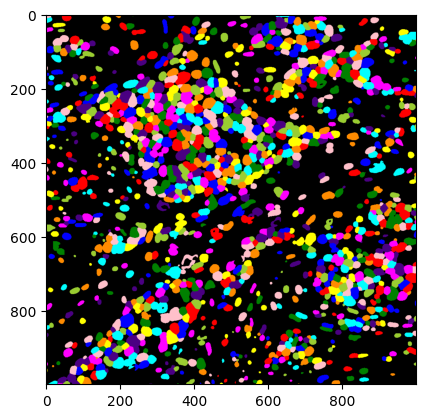

In [30]:
# visualizing a small tile
small = labeled[10000:11000, 10000:11000]
plt.imshow(label2rgb(small))

In [37]:
x = np.stack([tf.pages[i].asarray() for i in range(2)])
x = rearrange(x, 'c h w -> h w c')
x.shape

(60480, 19200, 2)

In [ ]:
x = 

In [ ]:
table = regionprops_table(labeled, x)